<a href="https://colab.research.google.com/github/abhiiyer/ERA1/blob/main/Session-10/ERA_Session10_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.07E+00


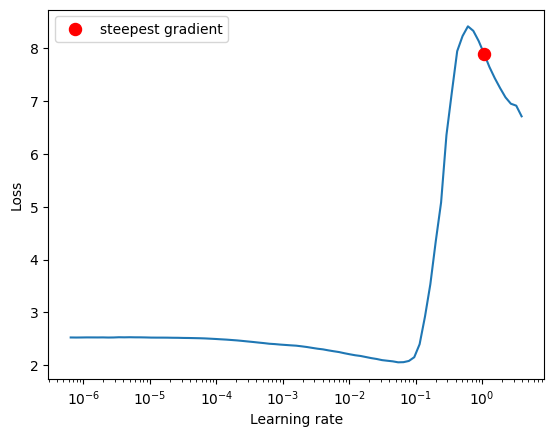

Min LR: 0.054623, Max LR: 0.613591
Epoch [1/24], LR: [0.0008509796720290955], Train Loss: 1.3564, Train Acc: 0.5135, Test Loss: 1.3044, Test Acc: 0.5710
Epoch [2/24], LR: [0.002119175911206604], Train Loss: 0.8704, Train Acc: 0.6918, Test Loss: 1.9984, Test Acc: 0.5228
Epoch [3/24], LR: [0.003966284249193859], Train Loss: 0.6919, Train Acc: 0.7609, Test Loss: 0.8919, Test Acc: 0.7195
Epoch [4/24], LR: [0.006045217889129314], Train Loss: 0.5960, Train Acc: 0.7945, Test Loss: 0.7222, Test Acc: 0.7675
Epoch [5/24], LR: [0.007965328159717826], Train Loss: 0.5131, Train Acc: 0.8235, Test Loss: 0.6337, Test Acc: 0.7867
Epoch [6/24], LR: [0.009365810602588684], Train Loss: 0.4587, Train Acc: 0.8412, Test Loss: 0.7615, Test Acc: 0.7668
Epoch [7/24], LR: [0.009983503087421717], Train Loss: 0.3901, Train Acc: 0.8659, Test Loss: 0.8743, Test Acc: 0.7315
Epoch [8/24], LR: [0.009942723378531746], Train Loss: 0.3442, Train Acc: 0.8807, Test Loss: 0.5331, Test Acc: 0.8252
Epoch [9/24], LR: [0.0097162

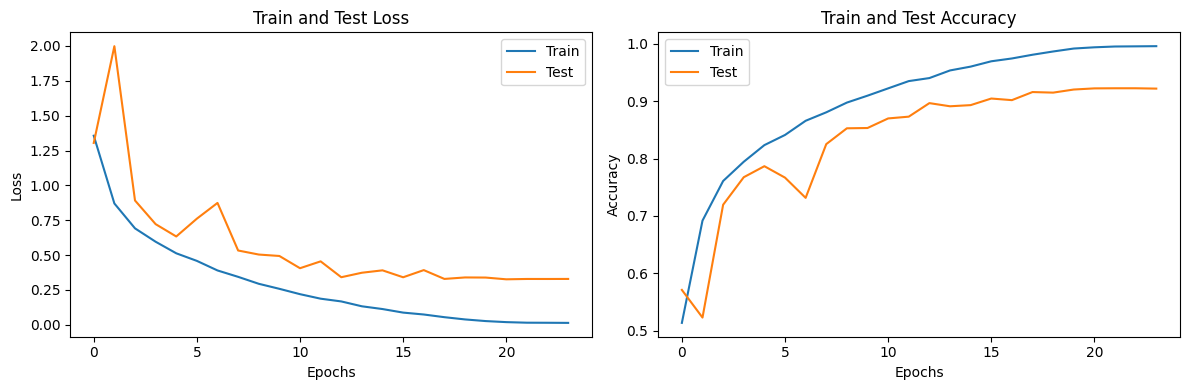

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet

!pip install torch_lr_finder -q --quiet

# For inline matplotlib plotting
%matplotlib inline

from model import ResNet
from utils import train, test, get_max_test_accuracy
from torch_lr_finder import LRFinder
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 24
batch_size = 512

# CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create ResNet model instance
model = ResNet().to(device)

# LR Finder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")

# Get LR Range
lr_finder.plot()  # Plot the loss versus learning rate
lr_finder.reset()  # Reset the model and optimizer to their initial state

min_lr = lr_finder.history["lr"][np.argmin(lr_finder.history["loss"])]
max_lr = lr_finder.history["lr"][np.argmax(lr_finder.history["loss"])]

print(f"Min LR: {min_lr:.6f}, Max LR: {max_lr:.6f}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(train_loader))

# Training loop
train_losses = []
train_acc = []
test_losses = []
test_acc = []
class_acc = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, scheduler)
    test_loss, test_accuracy, class_correct, class_total = test(model, device, test_loader, criterion)
    class_accuracy = [class_correct[i] / class_total[i] for i in range(10)]

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    class_acc.append(class_accuracy)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"LR: {scheduler.get_last_lr()}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Acc: {test_accuracy:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print maximum test accuracy and its corresponding epoch
max_test_acc, max_epoch = get_max_test_accuracy(test_acc)
print(f"Maximum Test Accuracy: {max_test_acc:.4f} at Epoch: {max_epoch + 1}")


In [5]:
# Print per-class accuracy
class_acc = np.array(class_acc)
for i in range(10):
    print(f"Accuracy of {class_labels[i]}: {class_acc[-1, i]:.4f}")

Accuracy of plane: 0.9360
Accuracy of car: 0.9750
Accuracy of bird: 0.8860
Accuracy of cat: 0.8360
Accuracy of deer: 0.9310
Accuracy of dog: 0.8730
Accuracy of frog: 0.9480
Accuracy of horse: 0.9400
Accuracy of ship: 0.9470
Accuracy of truck: 0.9480


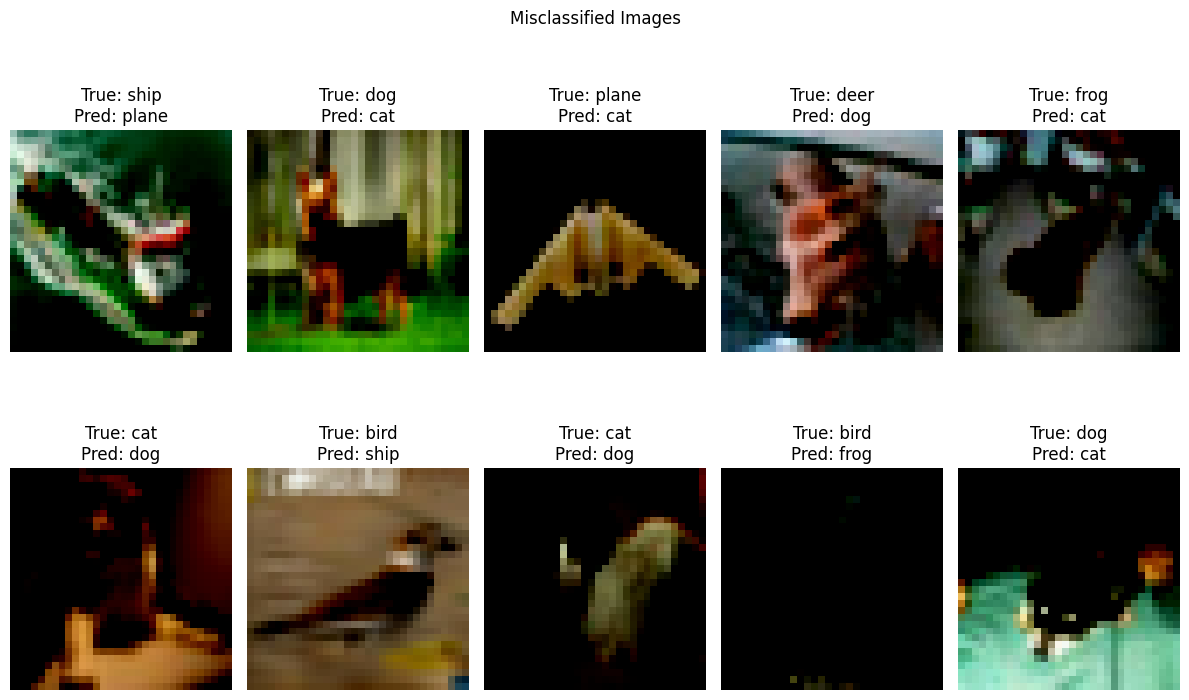

In [6]:
# Misclassified images
model.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        incorrect_indices = (predicted != labels).nonzero()[:, 0]
        for idx in incorrect_indices:
            misclassified_images.append(images[idx].cpu())
            misclassified_labels.append(labels[idx].cpu())
            misclassified_preds.append(predicted[idx].cpu())

# Display misclassified images
num_samples = min(len(misclassified_images), 10)
num_cols = 5
num_rows = (num_samples + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle('Misclassified Images')
for i, ax in enumerate(axes.flat):
    if i < num_samples:
        image = misclassified_images[i]
        label = misclassified_labels[i].item()
        pred = misclassified_preds[i].item()
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.axis('off')
        ax.set_title(f'True: {class_labels[label]}\nPred: {class_labels[pred]}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()
